In this journal, we aim to train a functioning audio sentiment model. This model would be utilised in an analyser, which can be represented as:

Audio Object -------> Sentiment Analyser ------> Sentiment Object

The file names for each audio file describes various details about the short audio clip that comes with it, including the emotion. We will use emotion attached to train the model.

In [5]:
import os
from fetch_emotion import get_emotion_number, get_emotion_str
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation
from keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt

In [6]:
# Set number of threads
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

In [7]:
n_labels = 7
path = '../audiofiles'

Here, we want to have all the files available for training. We will skip non-wav files.

In [8]:
file_names = []
for path, _, files in os.walk(path):
    for name in files:
        if name[-3:] == 'wav':
            file_names.append(os.path.join(path, name))

Audio features have to be extracted from each audio sample into a data frame.

In [9]:
# Initialise dataframe with 3 columns for features of name, features and emotion
df = pd.DataFrame(columns=['name', 'feature', 'emotion'])

In [10]:
for i, name in enumerate(file_names):
    # Extract data from audio file     
    X, sample_rate = librosa.load(name, res_type='kaiser_fast', duration=3, sr=22050*2, offset=0.5)
    sample_rate = np.array(sample_rate)
    # Get features of audio data and attach label
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    # Extract label from name    
    label = get_emotion_number(name)
    df.loc[i] = [name, mfccs, label]

Preprocess into suitable dimensions.

In [7]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
labelled_df = pd.concat([feature_df, df['emotion']], axis=1)
labelled_df = labelled_df.dropna()
shuffled_df = labelled_df.sample(frac=1).reset_index(drop=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis=1), 
                                                    shuffled_df['emotion'], 
                                                    test_size=0.3, 
                                                    random_state=17, 
                                                    shuffle = True)

In [9]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

Training the model.

In [59]:
model = Sequential()

# Layer 1
model.add(Conv1D(256, 5, padding='same', input_shape=(x_train_exp.shape[1], 1)))
model.add(Activation('relu'))

# layer 2
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))

# Regularisation and Pooling
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))

# Layer 3
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))

# Converge Nodes and conversion to probability distribution
model.add(Flatten())
model.add(Dense(n_labels)) 
model.add(Activation('softmax')) 

opt = keras.optimizers.RMSprop(learning_rate=0.0001, weight_decay=1e-6)

In [60]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [61]:
history = model.fit(x_train_exp, y_train, batch_size=256, epochs=600, validation_data=[x_test_exp, y_test])

Epoch 1/600
7/7 [==============================] - 3s 285ms/step - loss: 5.6434 - accuracy: 0.1620 - val_loss: 2.2827 - val_accuracy: 0.1712
Epoch 2/600
7/7 [==============================] - 2s 285ms/step - loss: 3.9493 - accuracy: 0.1760 - val_loss: 1.9257 - val_accuracy: 0.2758
Epoch 3/600
7/7 [==============================] - 2s 261ms/step - loss: 3.4546 - accuracy: 0.1772 - val_loss: 1.9769 - val_accuracy: 0.1793
Epoch 4/600
7/7 [==============================] - 2s 268ms/step - loss: 2.9407 - accuracy: 0.2028 - val_loss: 1.7426 - val_accuracy: 0.2976
Epoch 5/600
7/7 [==============================] - 2s 260ms/step - loss: 2.6914 - accuracy: 0.2005 - val_loss: 1.9415 - val_accuracy: 0.1753
Epoch 6/600
7/7 [==============================] - 2s 244ms/step - loss: 2.3844 - accuracy: 0.2314 - val_loss: 1.8343 - val_accuracy: 0.2351
Epoch 7/600
7/7 [==============================] - 2s 243ms/step - loss: 2.3336 - accuracy: 0.2209 - val_loss: 1.7320 - val_accuracy: 0.2812
Epoch 8/600
7

Epoch 59/600
7/7 [==============================] - 2s 244ms/step - loss: 1.3302 - accuracy: 0.5035 - val_loss: 1.4051 - val_accuracy: 0.4891
Epoch 60/600
7/7 [==============================] - 2s 251ms/step - loss: 1.3155 - accuracy: 0.4953 - val_loss: 1.3778 - val_accuracy: 0.5312
Epoch 61/600
7/7 [==============================] - 2s 233ms/step - loss: 1.3508 - accuracy: 0.4726 - val_loss: 1.3599 - val_accuracy: 0.5489
Epoch 62/600
7/7 [==============================] - 2s 241ms/step - loss: 1.3133 - accuracy: 0.5035 - val_loss: 1.3810 - val_accuracy: 0.5109
Epoch 63/600
7/7 [==============================] - 2s 231ms/step - loss: 1.2984 - accuracy: 0.5140 - val_loss: 1.3431 - val_accuracy: 0.5041
Epoch 64/600
7/7 [==============================] - 2s 266ms/step - loss: 1.3354 - accuracy: 0.4889 - val_loss: 1.3633 - val_accuracy: 0.5380
Epoch 65/600
7/7 [==============================] - 2s 268ms/step - loss: 1.2967 - accuracy: 0.5140 - val_loss: 1.3533 - val_accuracy: 0.5163
Epoch 

7/7 [==============================] - 2s 258ms/step - loss: 0.9353 - accuracy: 0.6614 - val_loss: 1.0748 - val_accuracy: 0.6277
Epoch 174/600
7/7 [==============================] - 2s 232ms/step - loss: 0.9194 - accuracy: 0.6649 - val_loss: 1.0391 - val_accuracy: 0.6590
Epoch 175/600
7/7 [==============================] - 2s 243ms/step - loss: 0.9221 - accuracy: 0.6556 - val_loss: 1.0499 - val_accuracy: 0.6562
Epoch 176/600
7/7 [==============================] - 2s 250ms/step - loss: 0.9028 - accuracy: 0.6585 - val_loss: 1.0724 - val_accuracy: 0.6440
Epoch 177/600
7/7 [==============================] - 2s 256ms/step - loss: 0.9324 - accuracy: 0.6498 - val_loss: 1.0288 - val_accuracy: 0.6617
Epoch 178/600
7/7 [==============================] - 2s 230ms/step - loss: 0.8978 - accuracy: 0.6702 - val_loss: 1.0650 - val_accuracy: 0.6372
Epoch 179/600
7/7 [==============================] - 2s 236ms/step - loss: 0.8931 - accuracy: 0.6742 - val_loss: 1.0165 - val_accuracy: 0.6617
Epoch 180/600

7/7 [==============================] - 2s 241ms/step - loss: 0.6924 - accuracy: 0.7529 - val_loss: 0.9222 - val_accuracy: 0.6753
Epoch 288/600
7/7 [==============================] - 2s 249ms/step - loss: 0.6988 - accuracy: 0.7506 - val_loss: 0.8679 - val_accuracy: 0.7106
Epoch 289/600
7/7 [==============================] - 2s 239ms/step - loss: 0.6688 - accuracy: 0.7640 - val_loss: 0.9376 - val_accuracy: 0.6807
Epoch 290/600
7/7 [==============================] - 2s 245ms/step - loss: 0.6821 - accuracy: 0.7477 - val_loss: 0.9164 - val_accuracy: 0.6807
Epoch 291/600
7/7 [==============================] - 2s 248ms/step - loss: 0.6837 - accuracy: 0.7512 - val_loss: 0.8697 - val_accuracy: 0.6984
Epoch 292/600
7/7 [==============================] - 2s 249ms/step - loss: 0.6847 - accuracy: 0.7582 - val_loss: 0.8563 - val_accuracy: 0.7147
Epoch 293/600
7/7 [==============================] - 2s 249ms/step - loss: 0.6666 - accuracy: 0.7704 - val_loss: 0.9235 - val_accuracy: 0.6440
Epoch 294/600

7/7 [==============================] - 2s 228ms/step - loss: 0.5301 - accuracy: 0.8083 - val_loss: 0.7779 - val_accuracy: 0.7364
Epoch 402/600
7/7 [==============================] - 2s 226ms/step - loss: 0.5130 - accuracy: 0.8071 - val_loss: 0.7919 - val_accuracy: 0.7215
Epoch 403/600
7/7 [==============================] - 2s 250ms/step - loss: 0.5048 - accuracy: 0.8234 - val_loss: 0.8002 - val_accuracy: 0.7106
Epoch 404/600
7/7 [==============================] - 2s 252ms/step - loss: 0.5157 - accuracy: 0.8176 - val_loss: 0.8299 - val_accuracy: 0.6984
Epoch 405/600
7/7 [==============================] - 2s 255ms/step - loss: 0.5169 - accuracy: 0.8089 - val_loss: 0.8108 - val_accuracy: 0.7120
Epoch 406/600
7/7 [==============================] - 2s 247ms/step - loss: 0.5383 - accuracy: 0.8118 - val_loss: 0.7873 - val_accuracy: 0.7242
Epoch 407/600
7/7 [==============================] - 2s 257ms/step - loss: 0.4981 - accuracy: 0.8234 - val_loss: 0.7735 - val_accuracy: 0.7337
Epoch 408/600

7/7 [==============================] - 2s 246ms/step - loss: 0.3908 - accuracy: 0.8631 - val_loss: 0.7130 - val_accuracy: 0.7473
Epoch 516/600
7/7 [==============================] - 2s 239ms/step - loss: 0.4013 - accuracy: 0.8584 - val_loss: 0.7144 - val_accuracy: 0.7418
Epoch 517/600
7/7 [==============================] - 2s 246ms/step - loss: 0.3912 - accuracy: 0.8677 - val_loss: 0.7257 - val_accuracy: 0.7378
Epoch 518/600
7/7 [==============================] - 2s 247ms/step - loss: 0.4146 - accuracy: 0.8566 - val_loss: 0.7502 - val_accuracy: 0.7310
Epoch 519/600
7/7 [==============================] - 2s 256ms/step - loss: 0.3949 - accuracy: 0.8613 - val_loss: 0.7672 - val_accuracy: 0.7228
Epoch 520/600
7/7 [==============================] - 2s 253ms/step - loss: 0.3804 - accuracy: 0.8648 - val_loss: 0.7238 - val_accuracy: 0.7486
Epoch 521/600
7/7 [==============================] - 2s 249ms/step - loss: 0.3874 - accuracy: 0.8549 - val_loss: 0.7341 - val_accuracy: 0.7432
Epoch 522/600

Trainig Completed. Display results.

In [62]:
train_result = model.evaluate(x_train_exp, y_train, verbose=0)
test_result = model.evaluate(x_test_exp, y_test, verbose=0)

In [63]:
print("Train", "%s: %.2f%%" % (model.metrics_names[1], train_result[1] * 100))
print("Test", "%s: %.2f%%" % (model.metrics_names[1], test_result[1] * 100))

Train accuracy: 95.63%
Test accuracy: 75.95%


We have now finished training the model and so we can save and start using it.

In [64]:
model_name = 'Audio_Sentiment_Model.h5'
save_dir = os.getcwd()
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

Having completed training, we can have a look at how the model performs and find any information that is useful to note. 

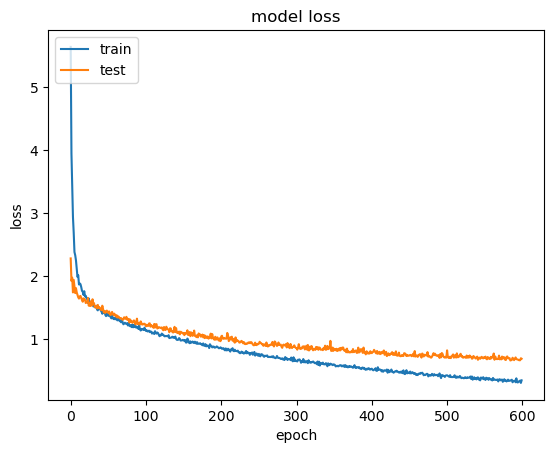

In [70]:
# Loss plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

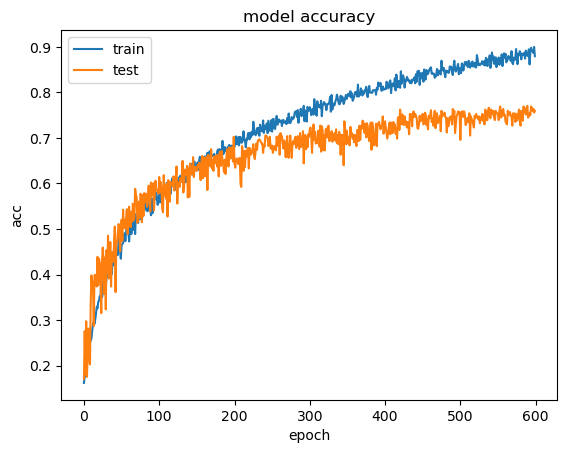

In [69]:
# Accuracy plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [11]:
# Load Model and Make Predictions on all data
model = load_model('Audio_Sentiment_Model.h5')
feature_df = pd.DataFrame(df['feature'].values.tolist())
x = np.expand_dims(feature_df, axis=2)
preds = model.predict(x)

77/77 [==============================] - 1s 13ms/step


We can have a look at which emotions are being wrongly guessed.

In [24]:
pred_labels = np.argmax(preds, axis=1)
pred_df = pd.DataFrame({'predictions':pred_labels})
result_df = pd.concat([df, pred_df], axis=1).drop('feature', axis=1)

# Count occurrences of each emotion
emotion_counts = result_df['emotion'].value_counts()

# Count occurrences of wrong predictions
wrong_predictions = result_df[result_df['emotion'] != result_df['predictions']]
wrong_prediction_counts = wrong_predictions['emotion'].value_counts()

# Create a new DataFrame for emotion, occurrences, and wrong predictions
counts_df = pd.DataFrame({'emotion': emotion_counts.index, 
                          'occurrences': emotion_counts.values, 
                          'wrong predictions': wrong_prediction_counts.values,
                          'percentage': wrong_prediction_counts.values / emotion_counts.values * 100})

counts_df['Emotion'] = counts_df['Emotion'].map(lambda x : get_emotion_str(x))
counts_df

,Emotion,Occurrences,Wrong Predictions,Percentage
0,neutral,564,82,14.539007
1,sad,376,36,9.574468
2,fearful,376,36,9.574468
3,angry,376,32,8.510638
4,happy,376,27,7.180851
5,surprised,192,20,10.416667
6,digust,192,19,9.895833


We can look at which correct-wrong pairs are being guessed most.

In [33]:
# Count the occurrences of each 'actual-wrong' pair
correct_wrong_counts = wrong_predictions.groupby(['emotion', 'predictions']).size().reset_index(name='count')
correct_wrong_counts['emotion'] = correct_wrong_counts['emotion'].map(lambda x : get_emotion_str(x))
correct_wrong_counts['predictions'] = correct_wrong_counts['predictions'].map(lambda x : get_emotion_str(x))
correct_wrong_counts = correct_wrong_counts.sort_values(by=['emotion', 'count'], ascending=False)

correct_wrong_counts

,emotion,predictions,count
33,surprised,happy,9
36,surprised,digust,7
32,surprised,neutral,6
34,surprised,sad,3
35,surprised,angry,2
9,sad,neutral,16
12,sad,fearful,7
14,sad,surprised,5
10,sad,happy,4
13,sad,digust,3


It looks like the fearful-sad pair occurs a lot. Perhaps we can understand better if we know if the emotion was normal or strong.

We can look at it predicts different emotions whether it was labelled as strong or normal.

Additionally, we can see if there's an effect on the model whether the audio clip was speech or song.

In [ ]:
# TODO: